In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [143]:
class OptimizerAgent(nn.Module):
    def __init__(self, hidden_dim, n_layers):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.gru = nn.GRU(1, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        out, self.h = self.gru(x, self.h.detach())
        out = self.fc(out)
        return out
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        self.h = hidden

In [144]:
def generate_problem(n):
    A = torch.randn(n,n)
    A = A.T@A
    b = torch.randn(n)
    b = A.T@b
    f = lambda x: .5*x@(A@x) - b@x
    grad_f = lambda x: A@x - b
    x0 = torch.randn(n)
    return f, grad_f, x0

In [185]:


def run_epoch(agent, opt, n_iter=100):
    agent.init_hidden(n)
    f, grad_f, x0 = generate_problem(n)

    x = x0.clone()
    loss = torch.tensor(0.)

    for i in range(n_iter+2):
        loss += f(x)
        g = grad_f(x)

        g = agent(g.data.unsqueeze(-1).unsqueeze(-1))
        x = x + g.squeeze().squeeze()

        if i>1 and i % 20 == 1:
            opt.zero_grad()
            loss.backward()
            opt.step()

            loss = torch.tensor(0.)
            x = x.detach()

    return loss

0.22818199
0.3142818
0.46249577
0.43732443
0.6351057
0.13035144
0.009931916
0.0055180774
0.014395106
0.0020647675
0.0033301774
0.0013482135
0.0065362426
0.00010617877
0.0005827461
0.009844428
0.0051839147
0.0024972125
0.003429862
0.004159238
0.009429584
0.0015401352
0.0071675195
0.006953779
0.0056012687
0.005216771
0.0016955545
0.0022665
0.0045311023
0.0055889604
0.0010386936
0.0022660675
0.0013923885
0.0016243716
0.001401907
0.0030286466
0.008895261
0.002554529
0.0009060696
0.00055333285


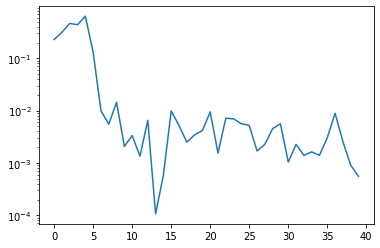

In [170]:
n = 10

agent = OptimizerAgent(20, 2)
opt = torch.optim.Adam(agent.parameters(), .003)

n_epochs = 40
final_losses = []

for _ in range(n_epochs):
    g_norms += [run_epoch(agent, opt)]

plt.plot(np.arange(len(g_norms)), g_norms)
plt.yscale('log')

In [182]:
opt_agent.init_hidden(n)
f, grad_f, x0 = generate_problem(n)

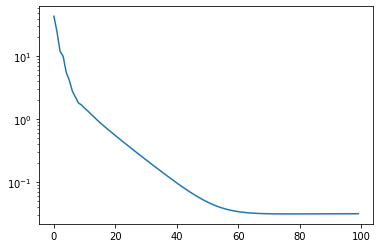

In [183]:
x = x0.clone()
g_norms = []

for i in range(n_iter):
    g = grad_f(x)
    g_norms += [np.linalg.norm(g.detach().numpy())]

    g = opt_agent(g.data.unsqueeze(-1).unsqueeze(-1))
    x = x + g.squeeze().squeeze()

plt.plot(np.arange(n_iter), g_norms)
plt.yscale('log')



In [184]:
g_norms[-1]

0.030967057

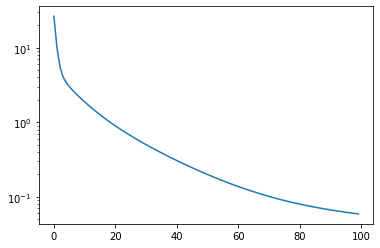

In [177]:
x = x0.clone()
g_norms = []

alpha = .05

for i in range(n_iter):
    g = grad_f(x)
    g_norms += [np.linalg.norm(g.detach().numpy())]

    x = x - alpha*g

plt.plot(np.arange(n_iter), g_norms)
plt.yscale('log')